In [1]:
import os
root_dir = "python"
_, current_folder = os.path.split(os.getcwd())
if current_folder != root_dir:
    os.chdir("../")

In [2]:
path = os.environ.get("PATH")
min_additional_path = "C:\\Users\\Michi\\Anaconda3\\envs\\python_v3-8\\Library\\bin;C:\\Users\\micha\\anaconda3\\envs\\ai38\\Library\\bin;"
combined_path = min_additional_path + path
os.environ["PATH"] = combined_path

In [3]:
from audio_recording import AudioRecording
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [271]:
participant_ids = os.listdir("data/Coswara_processed/Recordings/")
participant = random.choice(participant_ids)
participant_path = os.path.join("data", "Coswara_processed", "Recordings", participant)
participant_path

'data\\Coswara_processed\\Recordings\\QQx7MsHhXfPFNPjPAydYMmTWkpo2'

In [272]:
breath_recording = AudioRecording(participant_path, type_of_recording="cough-heavy")

Duration of the Recording: 1.72


In [273]:
breath_recording.play_audio()

Duration of the Recording: 1.72


In [274]:
audio, sr = breath_recording.get_audio()

Duration of the Recording: 1.72


In [275]:
round(len(audio)/sr, 2), sr

(1.72, 48000)

In [285]:
window_length = 1024
n_fft=16*1024
hop_size=512

In [286]:
stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_size, win_length=window_length)

In [287]:
stft.shape, len(audio)/hop_size

((8193, 162), 161.0)

In [288]:
np.abs(stft).shape

(8193, 162)

In [289]:
frequency_axis = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
max(frequency_axis)

24000.0

In [290]:
df = frequency_axis[1]-frequency_axis[0]
df  #frequency resolution

2.9296875

In [291]:
indices = np.array(range(stft.shape[1]))
time_axis = librosa.frames_to_time(indices, sr=sr, hop_length=hop_size)

In [292]:
plt.rcParams["figure.figsize"] = [8., 6]

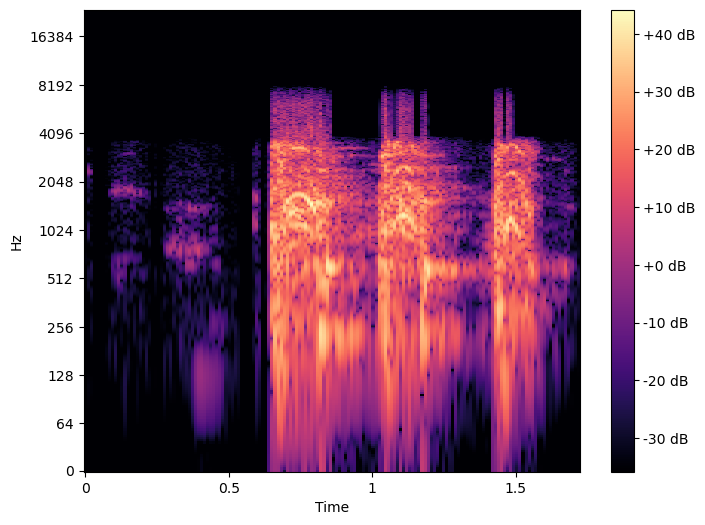

In [293]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft)), 
                               x_axis='time', y_axis='log', ax=ax,
                              hop_length=hop_size, n_fft=n_fft, sr=sr, cmap="magma")
fig.colorbar(img, ax=ax, format="%+2.f dB")

[(0.0, 2000.0), (0.0, 3.0)]

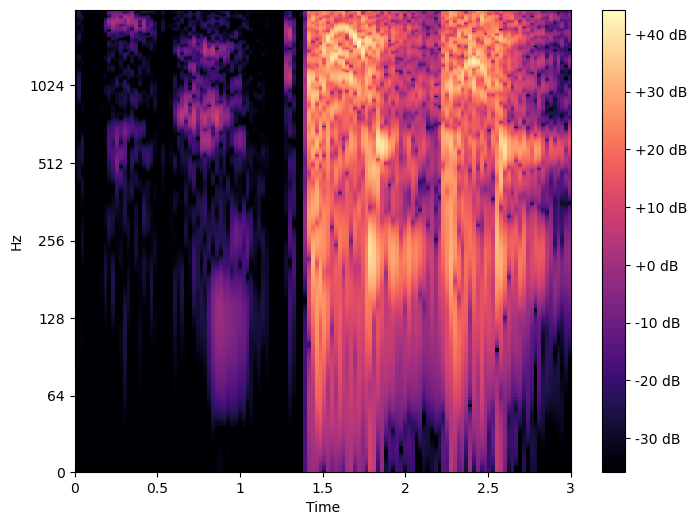

In [311]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft)), 
                               x_axis='time', y_axis='log', ax=ax, 
                               y_coords=frequency_axis, cmap="magma")
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.set(ylim=[0, 2000], xlim=[0, 3])

# new resnet features (takes 3x224x224)
If i use sr=22050 like before:<br />
256 samples = 12ms<br />
512 samples = 23ms (brogrammers hop size)<br />
1024 samples = 46ms<br />
2048 samples = 96ms (brogrammers n_fft)<br />

for sr=44100
256 samples = 6ms<br />
512 samples = 12ms <br />
1024 samples = 23ms<br />
2048 samples = 46ms <br />

## Log-Mel Spectrogram
from 20Hz to 10kHz (sr/2) there are 9 octaves
from 20 to 20.000 there are 10 (so not twice as many inputs but only 10/9=111%)

In [77]:
resnet_input_size = (3, 224, 224)

In [78]:
target_sr = 44100
audio_resampled = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)

In [79]:
temp=int(sr)
for i in range(10):
        temp=temp/2
        print(round(temp))

24000
12000
6000
3000
1500
750
375
188
94
47


### for a dimension of 224 in the resnet input we get << 25 >> frequencies per octave:

In [80]:
n_octaves = 9
n_freq_per_octave = resnet_input_size[1] / n_octaves
round(n_freq_per_octave)

25

In [218]:
window_length = 4096  # wen nfft 1024 ist zB, dann ist das gleich, wie wenn beide 512 sind 
                     # und das audio signal auf die 1024 zero gepadded wird
n_fft = 4096  * 16
hop_size = 512
n_mels = 224
fmax = target_sr/2
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0.0, fmax=fmax, htk=True)

mel_spect = librosa.feature.melspectrogram(y=audio, n_fft=n_fft, hop_length=hop_size, win_length=window_length,
                                           n_mels=n_mels, sr=target_sr, fmin=0.0, fmax=fmax)

(224, 1095)

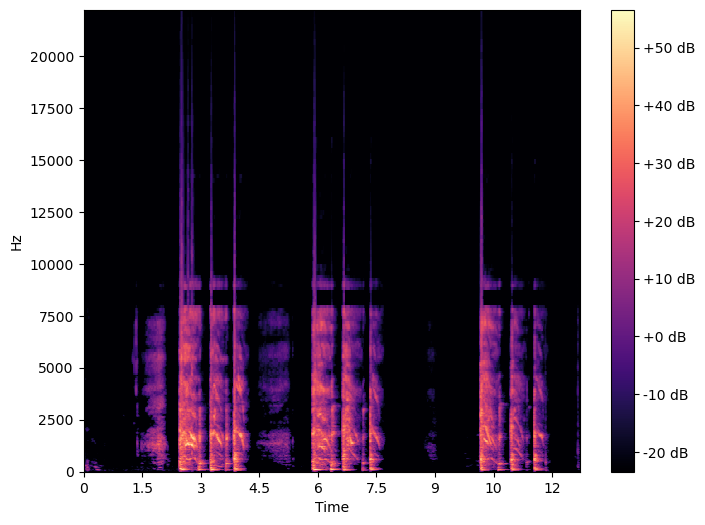

In [219]:
librosa.display.specshow(librosa.power_to_db(mel_spect), 
                         x_axis='time', y_axis="linear", cmap="magma", 
                         hop_length=hop_size, sr=target_sr, y_coords=mel_frequencies)
plt.colorbar(format="%+2.f dB")
mel_spect.shape

(10, 1095)

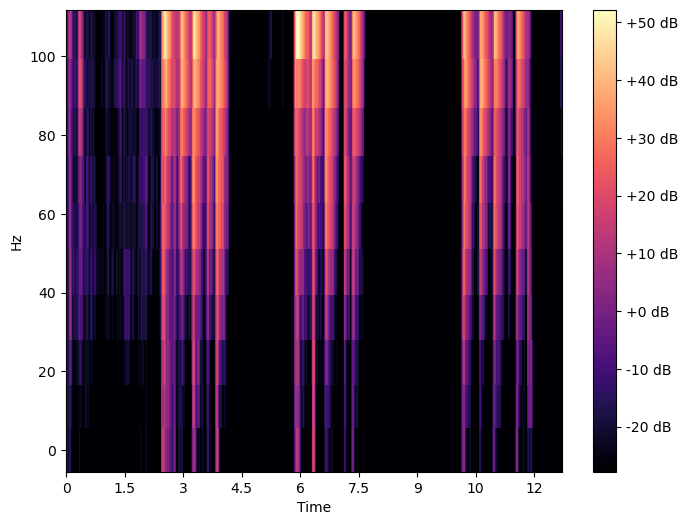

In [220]:
n_bins = 10
mel_spect_low = mel_spect[:n_bins, :]

librosa.display.specshow(librosa.power_to_db(mel_spect_low), 
                         x_axis='time', y_axis='linear', cmap="magma", 
                         hop_length=hop_size, sr=target_sr, y_coords=mel_frequencies[:n_bins])
#plt.xlim([1, 3])
plt.colorbar(format="%+2.f dB")
mel_spect_low.shape

# something is wrong with the mel bins. 
it should be always the same factor from one bin to the next
the low frequency resolution should probably also increase when increasing nfft

In [217]:
#mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0.0, fmax=target_sr/2)
fmin = 0
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)

mel_frequencies[:20]

array([  0.        ,  11.01340059,  22.20007974,  33.56276371,
        45.10422168,  56.82726635,  68.73475472,  80.82958872,
        93.11471594, 105.59313034, 118.26787299, 131.14203281,
       144.21874732, 157.50120339, 170.99263804, 184.69633923,
       198.61564663, 212.75395248, 227.11470236, 241.70139609])

In [194]:
factors = []
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax, htk=True)

for i in (range(len(mel_frequencies)-2)):
    factors.append(mel_frequencies[i+2] / mel_frequencies[i-1+2])
np.round(factors[:50], 2)

array([2.02, 1.51, 1.34, 1.26, 1.21, 1.18, 1.15, 1.13, 1.12, 1.11, 1.1 ,
       1.09, 1.09, 1.08, 1.08, 1.07, 1.07, 1.06, 1.06, 1.06, 1.06, 1.05,
       1.05, 1.05, 1.05, 1.05, 1.05, 1.04, 1.04, 1.04, 1.04, 1.04, 1.04,
       1.04, 1.04, 1.04, 1.04, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03,
       1.03, 1.03, 1.03, 1.03, 1.03, 1.03])

In [195]:
factors = []
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0.0, fmax=fmax, htk=False)

for i in (range(len(mel_frequencies)-2)):
    factors.append(mel_frequencies[i+2] / mel_frequencies[i-1+2])
np.round(factors[:50], 2)

array([2.  , 1.5 , 1.33, 1.25, 1.2 , 1.17, 1.14, 1.12, 1.11, 1.1 , 1.09,
       1.08, 1.08, 1.07, 1.07, 1.06, 1.06, 1.06, 1.05, 1.05, 1.05, 1.05,
       1.04, 1.04, 1.04, 1.04, 1.04, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03,
       1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 1.02, 1.02,
       1.02, 1.02, 1.02, 1.02, 1.02, 1.02])

In [92]:
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels)
mel_frequencies2 = librosa.mel_frequencies(n_mels=n_mels, htk=True)
np.round(mel_frequencies[:20]), np.round(mel_frequencies2[:20])

(array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 104., 119., 134., 149.,
        164., 179., 194., 209., 224., 239., 254., 269., 283.]),
 array([  0.,   9.,  18.,  27.,  36.,  46.,  55.,  65.,  74.,  84.,  94.,
        104., 115., 125., 135., 146., 157., 168., 179., 190.]))

In [149]:
# get new random participant audio
participant_ids = os.listdir("data/Coswara_processed/Recordings/")
participant = random.choice(participant_ids)
participant_path = os.path.join("data", "Coswara_processed", "Recordings", participant)
participant_path
breath_recording = AudioRecording(participant_path, type_of_recording="cough-heavy")
audio, sr = breath_recording.get_audio()

Duration of the Recording: 11.67
Duration of the Recording: 11.67


In [160]:
n_fft = 4096  * 16
hop_size = 512
n_mels = 224
fmax = target_sr/2
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0.0, fmax=fmax, htk=True)
lowest_window_length = 512
window_length_factor = 4


window_length = lowest_window_length
mel_spect1 = librosa.feature.melspectrogram(y=audio, n_fft=n_fft, hop_length=hop_size, win_length=window_length,
                                           n_mels=n_mels, sr=target_sr, fmin=0.0, fmax=fmax)

window_length = lowest_window_length*window_length_factor
mel_spect2 = librosa.feature.melspectrogram(y=audio, n_fft=n_fft, hop_length=hop_size, win_length=window_length,
                                           n_mels=n_mels, sr=target_sr, fmin=0.0, fmax=fmax)

window_length = lowest_window_length*window_length_factor*window_length_factor
mel_spect3 = librosa.feature.melspectrogram(y=audio, n_fft=n_fft, hop_length=hop_size, win_length=window_length,
                                           n_mels=n_mels, sr=target_sr, fmin=0.0, fmax=fmax)

print(lowest_window_length, lowest_window_length*window_length_factor, lowest_window_length*window_length_factor*window_length_factor)

512 2048 8192


In [162]:
mel_spect_full = np.stack([mel_spect1, mel_spect2, mel_spect3])
mel_spect_full.shape

(3, 224, 1095)

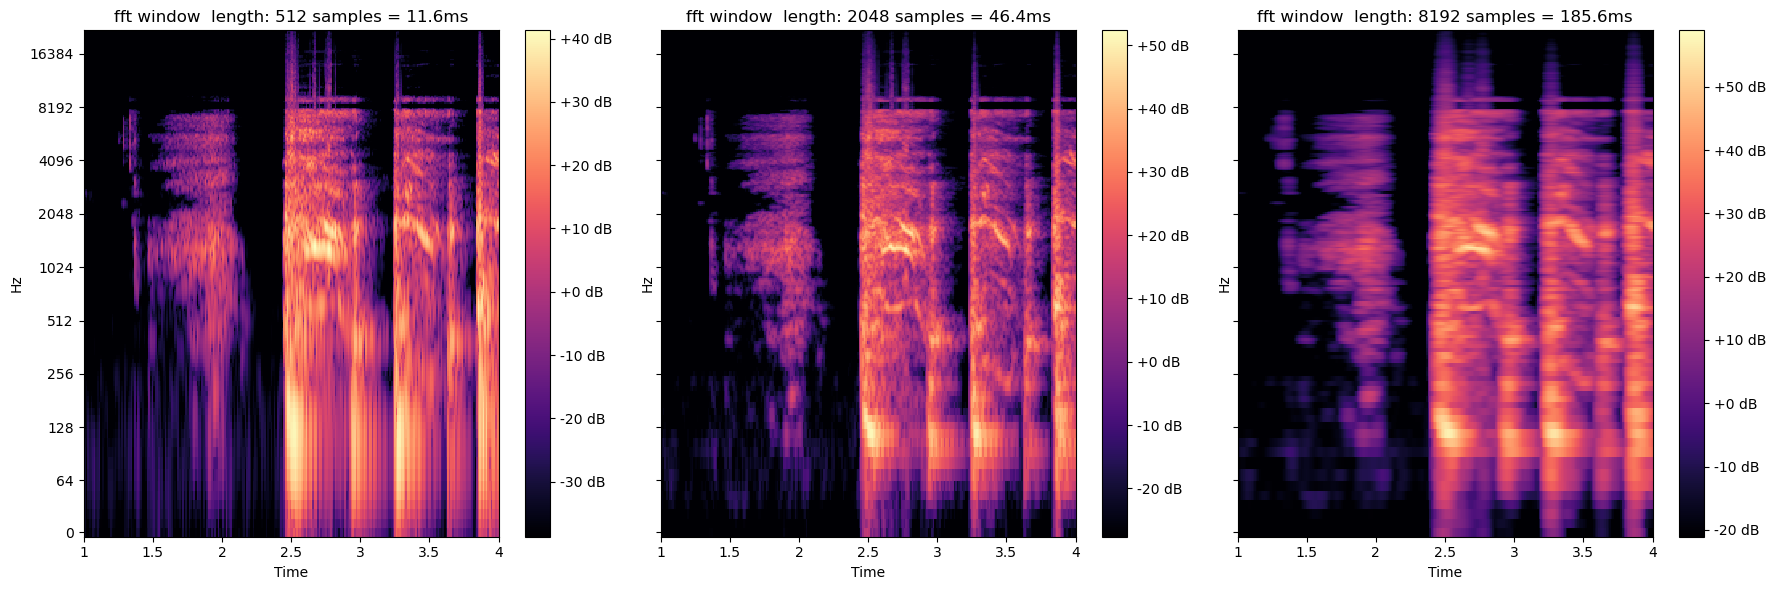

In [260]:
n_bins = 220
time_frame = (1, 4)
frequency_range = None
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0.0, fmax=fmax, htk=True)
titles = ["512 samples = 11.6ms", "2048 samples = 46.4ms", "8192 samples = 185.6ms"]


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=[18,6])
for i, ax in enumerate(axes):
    img = librosa.display.specshow(librosa.power_to_db(mel_spect_full[i]), x_axis='time', y_axis='log', cmap="magma", 
                                        hop_length=hop_size, sr=target_sr,  y_coords=mel_frequencies, ax=ax)
    if time_frame is not None:
        ax.set(xlim=[time_frame[0], time_frame[1]])
    if frequency_range is not None:
        ax.set(ylim=[frequency_range[0], frequency_range[1]])
    ax.set(title=f"fft window  length: {titles[i]}")
    fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()